In [3]:
%pip install kagglehub


Note: you may need to restart the kernel to use updated packages.


### download the dataset

In [ ]:
import os
import shutil
import kagglehub

download_path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

base_path = os.path.join(os.getcwd(), "cats_dogs_data")  
os.makedirs(base_path, exist_ok=True)

original_cat_dir = os.path.join(download_path, "PetImages", "Cat")
original_dog_dir = os.path.join(download_path, "PetImages", "Dog")

cat_target = os.path.join(base_path, "cats")
dog_target = os.path.join(base_path, "dogs")
os.makedirs(cat_target, exist_ok=True)
os.makedirs(dog_target, exist_ok=True)

def copy_first_n_images(src_dir, dst_dir, n=50, file_ext=".jpg"):
    files = sorted([f for f in os.listdir(src_dir) if f.endswith(file_ext)])
    for f in files[:n]:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir, f))

copy_first_n_images(original_cat_dir, cat_target, n=50)
copy_first_n_images(original_dog_dir, dog_target, n=50)

### load dataset

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강 + 정규화
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    'cats_dogs_data',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'cats_dogs_data',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='validation'
)


Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


### Transfer learning: Resnet50

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


In [10]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


c:\Users\wldhg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4898 - loss: 2.0087 - val_accuracy: 0.5000 - val_loss: 1.9151
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step - accuracy: 0.5170 - loss: 1.3542 - val_accuracy: 0.5000 - val_loss: 1.2389
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step - accuracy: 0.4132 - loss: 1.1495 - val_accuracy: 0.5000 - val_loss: 0.7986
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 696ms/step - accuracy: 0.5089 - loss: 0.7011 - val_accuracy: 0.6000 - val_loss: 0.7006
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 901ms/step - accuracy: 0.5288 - loss: 0.7616 - val_accuracy: 0.6000 - val_loss: 0.6814
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 883ms/step - accuracy: 0.6898 - loss: 0.6604 - val_accuracy: 0.6500 - val_loss: 0.6538
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 844ms/step - accuracy: 0.6726 - loss: 0.5447 - val_accuracy: 0.6000 - val_loss: 0.7020
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 848ms/step - accuracy: 0.7061 - loss: 0.5531 - val_accuracy: 0.6000 - val_loss: 0.

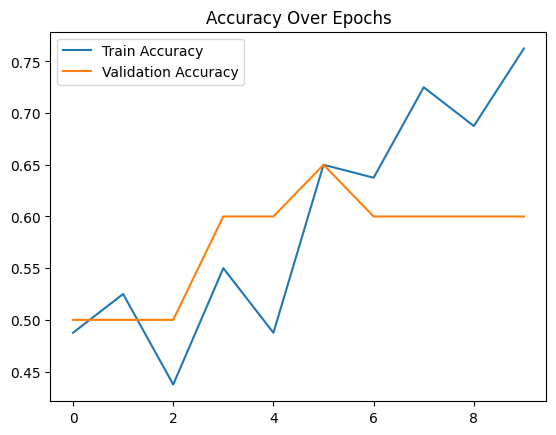

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()


### Fine-tuning

In [12]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# re-compile and training
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=5)


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5979 - loss: 0.8154 - val_accuracy: 0.5000 - val_loss: 1.0413
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step - accuracy: 0.7326 - loss: 0.6273 - val_accuracy: 0.5000 - val_loss: 0.9335
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 731ms/step - accuracy: 0.7922 - loss: 0.4826 - val_accuracy: 0.5000 - val_loss: 0.7568
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 866ms/step - accuracy: 0.6950 - loss: 0.4781 - val_accuracy: 0.5000 - val_loss: 0.7459
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 897ms/step - accuracy: 0.6759 - loss: 0.4895 - val_accuracy: 0.5000 - val_loss: 0.8438


###  Accuracy Output

In [ ]:
# Check accuracy based on validation dataset
loss, accuracy = model.evaluate(val_generator)
print(f"✅ Validation Accuracy: {accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.5208 - loss: 0.8151
✅ Validation Accuracy: 50.00%


### Predict New Image

In [16]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Load and resize image to match the model's input shape
    img = image.load_img(img_path, target_size=(224, 224))

    # Convert the image to a numpy array and normalize pixel values
    img_array = image.img_to_array(img) / 255.0

    # Add batch dimension (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)[0][0]

    # Interpret prediction result
    if prediction >= 0.5:
        print(f"Prediction: Dog ({prediction:.2f})")
    else:
        print(f"Prediction: Cat ({prediction:.2f})")

# Example usage: predict two images
predict_image('cats_dogs_data/test/cat.jpg')
predict_image('cats_dogs_data/test/dog.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: Cat (0.27)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Prediction: Cat (0.29)
